# Evaluating the Model

### Install Requirements

In [5]:
%%capture

!pip install fiftyone==1.1.0
!pip install pyzbar
!pip install opencv-python
!pip install seaborn
!pip install openpyxl

In [6]:
!pip install segment_anything

### Import Required Libraries

In [7]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import fiftyone as fo
import cv2
import matplotlib.pyplot as plt
import PIL
import requests

from pathlib import Path
from PIL import Image, ImageOps, ImageDraw, ImageFont
from PIL.ExifTags import TAGS
from pyzbar.pyzbar import decode, ZBarSymbol
from torchvision import transforms
from torchvision.ops import box_convert
from IPython.display import display
import argparse
import copy
from io import BytesIO

from detectron2 import model_zoo
from detectron2.utils.logger import setup_logger
from detectron2.engine import DefaultPredictor
from detectron2.data.catalog import Metadata
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode

from segment_anything import build_sam, SamPredictor
from pycocotools.coco import COCO

# Set up the logger for detectron2
setup_logger()


<Logger detectron2 (DEBUG)>

### Load SAM Model

In [8]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

sam_checkpoint = 'sam_vit_h_4b8939.pth'
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device=DEVICE)
sam_predictor = SamPredictor(sam)

### Specify Model

There are several output folders from training multiple models.  

In [17]:
import json

# name of output folder
output_folder_name = '2025_leaf_only_sam'

data_path = '/home/jovyan/work/data/2024-03-14_leaves'

coco_annotation_path = '/home/jovyan/work/data/2025_leaves.json'
with open(coco_annotation_path) as f:
    coco_data = json.load(f)

    coco_annotations = coco_data['annotations']
    coco_images_info = coco_data['images']
    coco_categories = coco_data['categories']


In [10]:
import numpy as np

def calculate_iou(gtmask, test_mask):
    intersection = np.logical_and(gtmask, test_mask)
    union = np.logical_or(gtmask, test_mask)
    iou_score = np.sum(intersection) / np.sum(union)
    return (iou_score)

# Usually there is a mask for the entire plant in addition to individual leaves. 
# This function attempts to remove the full plant mask by caclculating the iou of each mask and the union of all masks.
def check_full_plant(masks):
    # Initialize the combined mask
    mask_all = np.zeros(masks[0].shape, dtype=np.float32)

    # Combine all masks into one
    for mask in masks:
        mask_all += mask.astype(np.float32)

    iou_withall = []
    # Calculate IoU for each mask with the combined mask
    for mask in masks:
        iou_withall.append(calculate_iou(mask, mask_all))

    idx_notall = np.array(iou_withall) < 0.9
    return idx_notall

def annotate_masks_in_image(masks, image, include, random_color=True):
    # Convert image to RGBA
    annotated_frame_pil = Image.fromarray(image).convert("RGBA")

    
    # Iterate through each mask
    for i in range(masks.shape[0]):
        if (include[i]):
            mask = masks[i]
            if random_color:
                color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
            else:
                color = np.array([30/255, 144/255, 255/255, 0.6])

            h, w = mask.shape[-2:]
            mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

            mask_image_pil = Image.fromarray((mask_image * 255).astype(np.uint8)).convert("RGBA")

            # Composite the mask with the image
            annotated_frame_pil = Image.alpha_composite(annotated_frame_pil, mask_image_pil)
    
    return np.array(annotated_frame_pil)

# Returns relative bbox for FiftyOne and cropped mask
def get_bbox_for_plant(file_name):
    
    image_id = next(img['id'] for img in coco_data['images'] if img['file_name'] == file_name)

    # Get annotations for the image ID with label 'leaf'
    leaf_annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id and coco_data['categories'][ann['category_id']]['name'] == 'leaf']

    # Calculate the bounding box that encompasses all leaf annotations
    if leaf_annotations:
        x_min = min(ann['bbox'][0] for ann in leaf_annotations)
        y_min = min(ann['bbox'][1] for ann in leaf_annotations)
        x_max = max(ann['bbox'][0] + ann['bbox'][2] for ann in leaf_annotations)
        y_max = max(ann['bbox'][1] + ann['bbox'][3] for ann in leaf_annotations)
        plant_bbox = [x_min, y_min, x_max - x_min, y_max - y_min]
    else:
        plant_bbox = None

    return plant_bbox

def convert_bbox_to_full_image(bbox_cropped, bbox_full_image):
    x_min_cropped, y_min_cropped, width_cropped, height_cropped = bbox_cropped
    x_min_full, y_min_full, width_full, height_full = bbox_full_image

    x_min = x_min_full + x_min_cropped
    y_min = y_min_full + y_min_cropped
    x_max = x_min + width_cropped
    y_max = y_min + height_cropped

    return x_min, y_min, x_max, y_max

def adjust_mask(mask_cropped, bbox_cropped, full_image_shape):

    x_min_cropped, y_min_cropped, width_cropped, height_cropped = bbox_cropped
    full_image_height, full_image_width = full_image_shape[:2]

    if len(mask_cropped.shape) == 3 and mask_cropped.shape[0] == 1:
        mask_cropped = mask_cropped[0]

    # Create an empty mask for the full image
    mask_full = np.zeros((full_image_height, full_image_width), dtype=bool)

    # Determine the location in the full image where the cropped mask should be placed
    x_min_full = int(x_min_cropped)
    y_min_full = int(y_min_cropped)

    # Place the cropped mask in the corresponding location in the full image mask
    mask_full[y_min_full:y_min_full+mask_cropped.shape[0], x_min_full:x_min_full+mask_cropped.shape[1]] = mask_cropped

    return mask_full



In [11]:
import matplotlib.patches as patches

# x_min: The x-coordinate of the top-left corner of the bounding box.
# y_min: The y-coordinate of the top-left corner of the bounding box.
# width: The width of the bounding box.
# height: The height of the bounding box.

def visualize_bbox(image_path, bbox):
    img = Image.open(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    plt.show()

In [12]:
# Returns relative bbox for FiftyOne and cropped mask
def relative_mask_bbox(mask, file_name, image):
    
    plant_bbox = get_bbox_for_plant(file_name)
    # Assume we have the bbox of the full image
    
    if not plant_bbox:
        plant_bbox = [0, 0, image.shape[1], image.shape[0]]
    
    bbox_full_image = [0, 0, image.shape[1], image.shape[0]]  # Full image bounding box

    # Convert bbox to full image coordinates
    bbox_full = convert_bbox_to_full_image(plant_bbox, bbox_full_image)
    mask_full = adjust_mask(mask, plant_bbox, image.shape)
    

    # Find the coordinates of the nonzero elements in the mask
    nonzero_rows, nonzero_cols = np.nonzero(mask_full)

    # Calculate the bounding box of the leaf
    x_min = np.min(nonzero_cols)
    x_max = np.max(nonzero_cols)
    y_min = np.min(nonzero_rows)
    y_max = np.max(nonzero_rows)

    # Create an array representing the bounding box [x_min, y_min, width, height]
    cropped_mask = mask_full[y_min:y_max, x_min:x_max]\

    return x_min, y_min, x_max, y_max, cropped_mask

        

In [13]:
def is_bbox_large(bbox, threshold=0.9):
    """
    Check if bbox covers a large portion of the image.

    Parameters:
    - bbox: List representing the bounding box [x, y, width, height].
    - threshold: Threshold percentage for considering a bbox as covering a large portion of the image.

    Returns:
    - True if bbox covers a large portion of the image, False otherwise.
    """
    _, _, width, height = bbox
    bbox_area = width * height
    image_area = 1.0  # Assuming image area is 1 (normalized coordinates)
    return bbox_area >= threshold * image_area

def filter_large_bboxes(boxes, threshold=0.9):
    """
    Filter out bounding boxes that cover a large portion of the image.

    Parameters:
    - boxes: Tensor of bounding boxes in the format (left, top, width, height).
    - image_size: Tuple representing the size of the image (width, height).
    - threshold: Threshold percentage for considering a bbox as covering a large portion of the image.

    Returns:
    - Tensor of bounding boxes that do not cover a large portion of the image.
    """
    filtered_boxes = []
    for bbox in boxes:
        if not is_bbox_large(bbox, threshold):
            filtered_boxes.append(bbox)
    if len(filtered_boxes) > 0:
        return torch.stack(filtered_boxes)
    else:
        # Return an empty tensor with the same shape as the input boxes
        return torch.empty_like(boxes)

In [14]:
def check_color(masks, hsv):
    colors = np.zeros((0,3))

    for i in range(len(masks)):
        color = hsv[masks[i]['segmentation']].mean(axis=(0))
        colors = np.append(colors, color[None, :], axis=0)
    
    # Define a range for hue, saturation, and value (brightness)
    hue_lower_bound = 70
    hue_upper_bound = 100  # or 100 if grow lights are on
    saturation_lower_bound = 30
    value_lower_bound = 40  # Example value, adjust as needed
    value_upper_bound = 255  # Example value, adjust as needed

    idx_green = (colors[:,0] < hue_upper_bound) & (colors[:,0] > hue_lower_bound) & \
                (colors[:,1] > saturation_lower_bound) & \
                (colors[:,2] > value_lower_bound) & (colors[:,2] < value_upper_bound)

    if idx_green.sum() == 0:
        # If no greens found, adjust hue for grow lights
        hue_upper_bound = 100
        idx_green = (colors[:,0] < hue_upper_bound) & (colors[:,0] > hue_lower_bound) & \
                    (colors[:,1] > saturation_lower_bound) & \
                    (colors[:,2] > value_lower_bound) & (colors[:,2] < value_upper_bound)
    
    return idx_green

def generate_unique_color(existing_colors):
    """
    Generate a unique random color that's not in existing_colors.
    """
    while True:
        new_color = [random.randint(0, 255) for _ in range(3)]
        if not any((np.array(new_color) == x).all() for x in existing_colors):
            return new_color
    

class MaskColorAssigner:
    def __init__(self):
        self.bold_bright_colors = [
            np.array([255, 0, 0], dtype=np.uint8),     # Red
            np.array([0, 255, 0], dtype=np.uint8),     # Green
            np.array([0, 0, 255], dtype=np.uint8),     # Blue
            np.array([255, 255, 0], dtype=np.uint8),   # Yellow
            np.array([255, 0, 255], dtype=np.uint8),   # Magenta
            np.array([0, 255, 255], dtype=np.uint8),   # Cyan
            np.array([255, 165, 0], dtype=np.uint8),   # Orange
            np.array([128, 0, 128], dtype=np.uint8),   # Purple
            np.array([255, 20, 147], dtype=np.uint8),  # Deep Pink
            np.array([0, 128, 128], dtype=np.uint8),   # Teal
            np.array([255, 105, 180], dtype=np.uint8), # Hot Pink
            np.array([255, 69, 0], dtype=np.uint8),    # Red-Orange
            np.array([173, 255, 47], dtype=np.uint8),  # Green-Yellow
            np.array([75, 0, 130], dtype=np.uint8),    # Indigo
            np.array([240, 128, 128], dtype=np.uint8), # Light Coral
            np.array([0, 191, 255], dtype=np.uint8),   # Deep Sky Blue
            np.array([123, 104, 238], dtype=np.uint8), # Medium Slate Blue
            np.array([0, 255, 127], dtype=np.uint8),   # Spring Green
            np.array([255, 218, 185], dtype=np.uint8), # Peach Puff
            np.array([189, 183, 107], dtype=np.uint8), # Dark Khaki
            np.array([220, 20, 60], dtype=np.uint8)    # Crimson
        ]
        self.used_colors = set()

    def get_unique_color(self):
        available_colors = [color for color in self.bold_bright_colors if tuple(color) not in self.used_colors]
        if not available_colors:
            raise ValueError("Ran out of unique colors to assign")
        color = random.choice(available_colors)
        self.used_colors.add(tuple(color))
        return color

def apply_mask_to_image(image, mask, color_assigner):
    """
    Apply a single mask to the image, creating a colored overlay with a solid border
    """
    # Get a unique color from the color assigner
    color = color_assigner.get_unique_color()
    
    # Create an overlay that is a copy of the original image
    overlay = image.copy()
    
    # Resize mask to match image dimensions
    resized_mask = cv2.resize(mask.astype(float), (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
    resized_mask = resized_mask > 0.5  # Ensure binary mask
    
    # Apply the color to the overlay where the mask is true
    overlay[resized_mask] = overlay[resized_mask] * 0.5 + color * 0.5
    
    # Find contours of the mask
    contours, _ = cv2.findContours(resized_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw a solid border around the leaf
    cv2.drawContours(overlay, contours, -1, color.tolist(), thickness=2)
    
    return overlay


In [15]:
def issubset(mask1, mask2):
    # is mask2 subpart of mask1
    intersection = np.logical_and(mask1, mask2)
    return(np.sum(intersection)/mask2.sum()>0.8)

def intersect(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    return(np.sum(intersection)/mask2.sum())

# is_too_big = the larger of two overlapping masks
def istoobig(masks):
    idx_toobig = []
    
    mask_all = np.zeros(masks[0]['segmentation'].shape[:2])

    for mask in masks:
        mask_all +=mask['segmentation']*1 

    for idx, mask1 in enumerate((masks)):
        # print('\n')
        # print(idx)
        if idx in idx_toobig:
            continue
        for idx2, mask2 in enumerate((masks)):
            # print(idx2)
            if idx==idx2:
                continue
            if idx2 in idx_toobig:
                continue
            # print('intersection: ', intersect(mask1['segmentation'], mask2['segmentation']))
            if issubset(mask1['segmentation'], mask2['segmentation']):
                # print('issubset')
                # check if actually got both big and small copy delete if do
                if mask_all[masks[idx2]['segmentation']].mean() > 1:
                
                    idx_toobig.append(idx2)
            else:
                # print('check iou')
                iou_score = calculate_iou(mask1['segmentation'], mask2['segmentation'])
                # print('iou: ', iou_score)
                if iou_score > 0.4:
                    # If there's a significant overlap, and mask1 is bigger than mask2
                    if np.sum(mask1['segmentation']) <= np.sum(mask2['segmentation']):
                        idx_toobig.append(idx2)
                        break  # No need to check other masks for this idx
    
    idx_toobig.sort(reverse=True)        
    return(idx_toobig)


def remove_toobig(masks, idx_toobig):
    masks_ntb = masks.copy()

    idx_del = []
    for idxbig in idx_toobig:
        del(masks_ntb[idxbig])
            
    return(masks_ntb)


def getbiggestcontour(contours):
    nopoints = [len(cnt) for cnt in contours]
    return(np.argmax(nopoints))

def checkshape(masks):
    cratio = []

    for i in range(len(masks)):
        test_mask = masks[i]['segmentation']
        
        if not test_mask.max():
            cratio.append(0)
        else:

            contours,hierarchy = cv2.findContours((test_mask*255).astype('uint8'), 1, 2)

            # multiple objects possibly detected. Find contour with most points on it and just use that as object
            cnt = contours[getbiggestcontour(contours)]
            M = cv2.moments(cnt)

            area = cv2.contourArea(cnt)
            perimeter = cv2.arcLength(cnt,True)

            (x,y),radius = cv2.minEnclosingCircle(cnt)

            carea = np.pi*radius**2

            cratio.append(area/carea)
    idx_shape = np.array(cratio)>0.1
    return(idx_shape)

def check_full_plant_mask(masks):
    mask_all = np.zeros(masks[0]['segmentation'].shape[:2])

    for mask in masks:
        mask_all +=mask['segmentation']*1
        
    iou_withall = []
    for mask in masks:
        iou_withall.append(calculate_iou(mask['segmentation'], mask_all>0))
        
    idx_notall = np.array(iou_withall)<0.9
    return idx_notall

In [20]:
import numpy as np
from PIL import Image, ImageOps
import fiftyone as fo
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from skimage import color
import random
import os

today = '2025-02-06'
sam_image_dir = '/home/jovyan/work/data/leaves_cropped'
sam_output_folder = '/home/jovyan/work/data/leaf_only_sam/npz2'

dataset = fo.Dataset.from_dir(
    data_path=f"{data_path}",
    labels_path=f"{coco_annotation_path}",
    dataset_type=fo.types.COCODetectionDataset, 
    name=f"{today}_leaf_only_sam",
    label_types="segmentations",
    overwrite=True
)

with fo.ProgressBar() as pb:
    for sample in pb(dataset):
        image = Image.open(sample.filepath)
        file_name = os.path.basename(sample.filepath)
        print(file_name)
        image = ImageOps.exif_transpose(image)  # Ensure correct orientation
        image_arr = np.array(image)
        h, w, _ = image_arr.shape
        name, ext = os.path.splitext(file_name)
        

        # --------------------- Leaf Only SAM --------------------
        npz_file_path = f"{sam_output_folder}/{name}_croppedleafonly_allmasks.npz"
        cropped_image_path = f"{sam_image_dir}/{name}_cropped{ext}"

        try:
            mask_data = np.load(npz_file_path, allow_pickle=True)
        except:
            sample["leaf_only_sam_predictions"] = fo.Detections(detections=[])
            sample["height"] = h
            sample["width"] = w
            sample.tags.append(os.path.basename(sample.filepath))
            sample.save()
            continue

        cropped_image = mpimg.imread(cropped_image_path)
        overlay = np.zeros_like(cropped_image)
        used_colors = []
        all_masks = mask_data['arr_0']
        hsv = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2HSV)
        idx_green = check_color(all_masks, hsv)

        masks_g = [all_masks[idx] for idx, use in enumerate(idx_green) if use]

        if len(masks_g) > 2:
            idx_notall = check_full_plant_mask(masks_g)
            masks_na = [masks_g[idx] for idx, use in enumerate(idx_notall) if use]
        else:
            masks_na = masks_g

        idx_shape = checkshape(masks_na)
        masks_s = [masks_na[idx] for idx, use in enumerate(idx_shape) if use]

        if masks_s:
            idx_toobig = istoobig(masks_s)
            masks_ntb = remove_toobig(masks_s, idx_toobig)
        else:
            masks_ntb = []

        masked_image = cropped_image
        masks_not_too_small = []
        color_assigner = MaskColorAssigner()

        for mask in masks_ntb:
            segmentation_info = mask
            segmentation_mask = segmentation_info['segmentation']
            if np.count_nonzero(segmentation_mask) >= 400:
                unique_color = generate_unique_color(used_colors)
                used_colors.append(unique_color)
                masks_not_too_small.append(segmentation_mask)
                masked_image = apply_mask_to_image(masked_image, segmentation_mask, color_assigner)

        output_image = Image.fromarray(masked_image)
        output_image.save(f"/home/jovyan/work/data/leaf_only_sam/results/{name}_LOS_masks.png")

        leaf_only_sam_detections = []

        for mask_np in masks_not_too_small:
            x1, y1, x2, y2, bbox_mask = relative_mask_bbox(mask_np, file_name, image_arr)
            leaf_only_sam_detections.append(fo.Detection(
                label='leaf',
                bounding_box=[
                    min(x1, x2) / image.width,
                    min(y1, y2) / image.height,
                    abs(x2 - x1) / image.width,
                    abs(y2 - y1) / image.height
                ],
                mask=bbox_mask,
                confidence=0.9,
            ))

        sample["leaf_only_sam_predictions"] = fo.Detections(detections=leaf_only_sam_detections)
        sample["height"] = h
        sample["width"] = w
        sample.tags.append(os.path.basename(sample.filepath))
        sample.save()


 100% |█████████████████| 176/176 [48.3s elapsed, 0s remaining, 2.2 samples/s]      
IMG_5792.JPG                                                                 
IMG_5793.JPG                                                                       
IMG_5794.JPG                                                                       
IMG_5795.JPG                                                                       
IMG_5849.JPG                                                                       
IMG_5850.JPG                                                                       
IMG_5851.JPG                                                                       
IMG_5852.JPG                                                                       
IMG_5853.JPG                                                                       
IMG_5854.JPG                                                                       
IMG_5855.JPG                                                                     

In [27]:
from fiftyone import ViewField as F
# Evaluate detections

# Filter ground truth and predictions to only include 'leaf' detections
leaf_view = dataset.filter_labels("ground_truth", F("label") == "leaf")

results = leaf_view.evaluate_detections(
    "leaf_only_sam_predictions",          # Field with predicted detections
    gt_field="ground_truth",  # Ground truth field
    eval_key=f"leaf_only_sam_eval",        # Store evaluation results under this key
    compute_mAP=True,
)

# Get mAP for 'leaf' class
map_score = results.mAP()
print(f"Mean Average Precision (mAP) for 'leaf': {map_score:.4f}")

# Print classification report for 'leaf'
results.print_report(classes=["leaf"])

# Print TP, FP, FN specifically for 'leaf'
print("TP (leaf): %d" % leaf_view.sum("leaf_only_sam_eval_tp"))
print("FP (leaf): %d" % leaf_view.sum("leaf_only_sam_eval_fp"))
print("FN (leaf): %d" % leaf_view.sum("leaf_only_sam_eval_fn"))

Evaluating detections...
 100% |█████████████████| 169/169 [7.9s elapsed, 0s remaining, 12.4 samples/s]      
Performing IoU sweep...
 100% |█████████████████| 169/169 [2.9s elapsed, 0s remaining, 50.3 samples/s]      
Mean Average Precision (mAP) for 'leaf': 0.4356
              precision    recall  f1-score   support

        leaf       0.69      0.55      0.62      1001

   micro avg       0.69      0.55      0.62      1001
   macro avg       0.69      0.55      0.62      1001
weighted avg       0.69      0.55      0.62      1001

TP (leaf): 554
FP (leaf): 246
FN (leaf): 447


In [28]:
print(results.metrics())

{'accuracy': 0.4442662389735365, 'precision': 0.6925, 'recall': 0.5534465534465535, 'fscore': 0.6152137701277068, 'support': 1001}


In [29]:
import numpy as np

def compute_iou(mask1, mask2):
    """Compute IoU between two binary masks."""
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0

def match_predictions(pred_masks, gt_masks, iou_threshold):
    """Match predictions to ground truth masks based on IoU threshold."""
    tp, fp, fn = 0, 0, 0
    matched = set()

    for pred_mask in pred_masks:
        best_iou = 0
        best_gt_idx = -1

        for idx, gt_mask in enumerate(gt_masks):
            iou = compute_iou(pred_mask, gt_mask)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = idx

        if best_iou >= iou_threshold and best_gt_idx not in matched:
            tp += 1  # True Positive: Correctly detected leaf
            matched.add(best_gt_idx)
        else:
            fp += 1  # False Positive: Incorrect detection

    fn = len(gt_masks) - len(matched)  # False Negatives: Missed leaves
    return tp, fp, fn

def compute_precision_recall(pred_masks, gt_masks, iou_thresholds=np.arange(0.5, 1.0, 0.05)):
    """Compute precision, recall, and AP across IoU thresholds."""
    all_ap = []

    for iou_thresh in iou_thresholds:
        tp, fp, fn = match_predictions(pred_masks, gt_masks, iou_thresh)

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        # AP: Trapezoidal rule for PR curve integration (mAP@[50:95])
        all_ap.append(precision)

    return np.mean(all_ap)  # mAP over all IoU thresholds

def compute_dataset_map(all_pred_masks, all_gt_masks):
    """Compute mean Average Precision (mAP) for an entire FiftyOne dataset."""
    all_ap = []

    for pred_masks, gt_masks in zip(all_pred_masks, all_gt_masks):
        ap = compute_precision_recall(pred_masks, gt_masks)
        all_ap.append(ap)

    return np.mean(all_ap)  # Final mAP score


IMG_6056.JPG
IMG_6056
Precision:  1.0
Recall:  0.6428571428571429
Num matches: 18


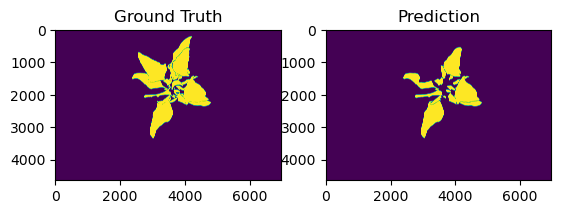

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def convert_to_pixels(bbox, height, width):
    x1, y1, w, h = bbox
    return [x1 * width, y1 * height, (x1 + w) * width, (y1 + h) * height]

def calculate_mask(detections, height, width):

    # rebuild full mask
    mask = np.zeros((height, width), dtype=bool)
    for d in detections:
        if d.label == 'leaf':
            bbox = d.bounding_box
            x1, y1, x2, y2 = convert_to_pixels(bbox, height, width)
            mask[round(y1):round(y2), round(x1):round(x2)] |= d.mask
    return mask

def calculate_iou_and_dice(gt_mask, pred_mask):
    # if np.count_nonzero(gt_mask) == 0 and np.count_nonzero(pred_mask) == 0:
    #     # Perfect agreement in the absence of objects
    #     return 1, 1
    
    intersect = np.logical_and(gt_mask, pred_mask)
    union = np.logical_or(gt_mask, pred_mask)
    intersect_pixels = np.count_nonzero(intersect)
    union_pixels = np.count_nonzero(union)
    
    # Normal IoU and Dice calculation when there are objects
    iou = intersect_pixels / union_pixels if union_pixels else None
    dice = (2 * intersect_pixels) / (np.count_nonzero(gt_mask) + np.count_nonzero(pred_mask)) if np.count_nonzero(gt_mask) + np.count_nonzero(pred_mask) else None
    
    return iou, dice

def visualize_masks(gt_mask, pred_mask):
    f, axarr = plt.subplots(1, 2)
    plt.rcParams['figure.figsize'] = [10, 10]
    axarr[0].title.set_text('Ground Truth')
    axarr[1].title.set_text('Prediction')
    axarr[0].imshow(gt_mask)
    axarr[1].imshow(pred_mask)
    plt.show()
    

def calculate_precision_recall(ground_truths, predictions, iou_threshold=0.5):
    matches = []
    matched_gt_indices = set()  # To track which ground_truths are matched

    # Matching detections between predictions and ground_truths
    for pred in predictions:
        best_iou = 0
        best_match_index = None
        for index, gt in enumerate(ground_truths):
            iou, dice = calculate_iou_and_dice(gt['bounding_box'], pred['bounding_box'])
            if iou > best_iou:
                best_iou = iou
                best_match_index = index
        if best_iou >= iou_threshold:
            matches.append((pred, ground_truths[best_match_index]))
            matched_gt_indices.add(best_match_index)
        else:
            matches.append((pred, None))
    
    true_positives = len([match for match in matches if match[1] is not None])
    false_positives = len(predictions) - true_positives
    false_negatives = len(ground_truths) - len(matched_gt_indices)  # Ground truths not matched

    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0

    return precision, recall, len(matches)

def calculate_pixel_level_precision_recall(gt_mask, pred_mask):
    TP = np.sum(np.logical_and(pred_mask == 1, gt_mask == 1))
    FP = np.sum(np.logical_and(pred_mask == 1, gt_mask == 0))
    FN = np.sum(np.logical_and(pred_mask == 0, gt_mask == 1))

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    return precision, recall


def calculate_precision_recall_count(ground_truths, predictions, iou_threshold=0.5):
    # Filter detections to include only those with the label 'leaf'
    filtered_ground_truths = [gt for gt in ground_truths if gt['label'] == 'leaf']
    filtered_predictions = [pred for pred in predictions if pred['label'] == 'leaf']

    matches = []
    matched_gt_indices = set()  # Tracks which ground_truths are matched

    # Matching detections between filtered predictions and filtered ground_truths
    for pred_index, pred in enumerate(filtered_predictions):
        best_iou = 0
        best_match_index = None
        for gt_index, gt in enumerate(filtered_ground_truths):
            if gt_index in matched_gt_indices:
                continue  # Skip already matched ground truths
            # print(gt)
            iou, _ = calculate_iou_and_dice(gt['bounding_box'], pred['bounding_box'])  # Dice can be ignored if not needed
            if iou > best_iou:
                best_iou = iou
                best_match_index = gt_index
        
        if best_iou >= iou_threshold:
            matches.append((pred, filtered_ground_truths[best_match_index]))
            matched_gt_indices.add(best_match_index)
        else:
            matches.append((pred, None))
    
    true_positives = len([match for match in matches if match[1] is not None])
    false_positives = len(filtered_predictions) - true_positives
    false_negatives = len(filtered_ground_truths) - len(matched_gt_indices)
    


    # Keep the original print statements
    # print('True positives: ', true_positives)
    # print('False positives: ', false_positives)
    # print('False negatives: ', false_negatives)

    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0

    return precision, recall, len(matches), true_positives, false_positives, false_negatives




sample = dataset.last()
print(sample.filename)
height, width = sample.height, sample.width
ground_truth_detections = sample.ground_truth.detections
predictions = sample.leaf_only_sam_predictions.detections

ground_truth_mask = calculate_mask(ground_truth_detections, height, width)
prediction_mask = calculate_mask(predictions, height, width)
filename = sample.filepath.split('/')[-1].split('.')[0]
print(filename)
precision, recall, num_matches, tp, fp, fn = calculate_precision_recall_count(ground_truth_detections, predictions)
print('Precision: ', precision)
print('Recall: ', recall)
print('Num matches:', num_matches)


visualize_masks(ground_truth_mask, prediction_mask)
    

In [ ]:
def count_leaves(detections):
    return sum(1 for d in detections if hasattr(d, 'label') and d.label == 'leaf')

In [34]:
import pandas as pd

# initialize dataframe from manual area file, and add column for ml_area
df = pd.read_excel('/home/jovyan/work/data/manual_area_count.xlsx')

columns_to_initialize = ['ml_area', 'leaf_only_sam_area', 'ml_leaf_count', 'ground_truth_pixels', 'prediction_pixels', 'iou', 'dice', 'count_precision', 'count_recall', 'num_matches', 'tp', 'fp', 'fn',  'mask_precision', 'mask_recall']

# Initialize columns to None and then convert to float
for column in columns_to_initialize:
    df[column] = None
    df[column] = df[column].astype(float)
    
missing_from_file = []

with fo.ProgressBar() as pb:

    
    fold_iou = []
    fold_dice = []

    for sample in dataset:

        filename = sample.filepath.split('/')[-1].split('.')[0]
        ground_truth_detections = sample.ground_truth.detections
        prediction_detections = sample.leaf_only_sam_predictions.detections
        
        ground_truth_mask = calculate_mask(ground_truth_detections, height, width)
        prediction_mask = calculate_mask(prediction_detections, height, width)

        height, width = sample.height, sample.width
        iou, dice = calculate_iou_and_dice(ground_truth_mask, prediction_mask)
        
        # print(dice)
        row = df['picture'].str.startswith(filename)
        
        df.loc[row, 'ground_truth_pixels'] = np.count_nonzero(ground_truth_mask)
        df.loc[row, 'prediction_pixels'] = np.count_nonzero(prediction_mask)
        df.loc[row, 'iou'] = round(iou, 3) if iou is not None else None
        df.loc[row, 'dice'] = round(dice, 3) if dice is not None else None
        
        fold_iou.append(iou)
        fold_dice.append(dice)

        # visualize_masks(ground_truth_mask, prediction_mask)
    
    fold_iou = np.array(fold_iou, dtype=float)
   

    print('Min IOU: ', np.nanmin(fold_iou))
    print('Max IOU: ', np.nanmax(fold_iou))
    print('Average IOU: ', np.nanmean(fold_iou))

    print('\n')
    fold_dice = np.array(fold_dice, dtype=float)
    print('Min Dice: ', np.nanmin(fold_dice))
    print('Max Dice: ', np.nanmax(fold_dice))
    print('Average Dice: ', np.nanmean(fold_dice))


# df_area = df[df['ml_area'] >= 0.0]
# pd.set_option('display.max_rows', None)  # None means unlimited
# pd.set_option('display.max_columns', None)

# # Calculate means for specific columns
# mean_values = {
#     'ground_truth_pixels': None,
#     'prediction_pixels': None,
#     'iou': np.nanmean(df['iou']),
#     'dice': np.nanmean(df['dice']),
#     'count_precision': df['count_precision'].mean(),
#     'count_recall': df['count_recall'].mean(),
#     'mask_precision': df['mask_precision'].mean(),
#     'mask_recall': df['mask_recall'].mean(),
#     'num_matches': None,
# }

# # Create a new DataFrame with the mean values
# mean_df = pd.DataFrame(mean_values, index=['average'])

# # Append the new DataFrame with averages to the original DataFrame
# df = pd.concat([df, mean_df])


# # Specify the path and name of the CSV file you want to create
# csv_file_path = f'{sam_output_folder}/{output_folder_name}.csv'

# # Export the DataFrame to CSV
# df.to_csv(csv_file_path, index=False)


Min IOU:  0.0
Max IOU:  0.9643111175442071
Average IOU:  0.5719936447792471


Min Dice:  0.0
Max Dice:  0.981831349353451
Average Dice:  0.6679529928434488
 0 [9.4s elapsed, ? remaining, ? samples/s] 


In [ ]:
session = fo.launch_app(datasets['fold_0'], port=5151, address="0.0.0.0")